In [ ]:
# IMPORT DATA
# PREPROCESSING
# FEATURE SELCETION


1. Import data
2. Preprocessing (encoding, normalization, handle missing)
3. Split train/test (75/25)
4. Balancing (di training set saja)
5. Feature selection (misal: RF importance, RFE)
6. (Optional) PCA or Autoencoder (dense, not LSTM)
7. Train model (XGBoost + cross validation)
8. Test model on hold-out test set
9. Evaluate (ROC, F1, Confusion matrix, SHAP)

=== Heart Failure Prediction Pipeline ===
1. Loading data...
Data shape: (299, 13)
Missing values: 0
Target distribution:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

2. Preprocessing data...
Features after preprocessing: (299, 12)

3. Splitting data (75/25)...
Training set: (224, 12)
Test set: (75, 12)
Training target distribution:
DEATH_EVENT
0    152
1     72
Name: count, dtype: int64

4. Balancing training data using smote...
Before balancing: {0: 152, 1: 72}
After balancing: {1: 152, 0: 152}

5. Feature selection using rf_importance...
Selected features (8): ['time', 'serum_creatinine', 'ejection_fraction', 'creatinine_phosphokinase', 'serum_sodium', 'platelets', 'age', 'high_blood_pressure']

7. Training XGBoost model...
Cross-validation AUC scores: [0.93010753 0.99139785 0.95698925 0.96129032 0.92666667]
Mean CV AUC: 0.9533 (+/- 0.0471)

8. Testing model on hold-out test set...

9. Model evaluation...
Test Set Performance:
Accuracy: 0.8800
F1-Score: 0.8000
AUC-ROC: 0

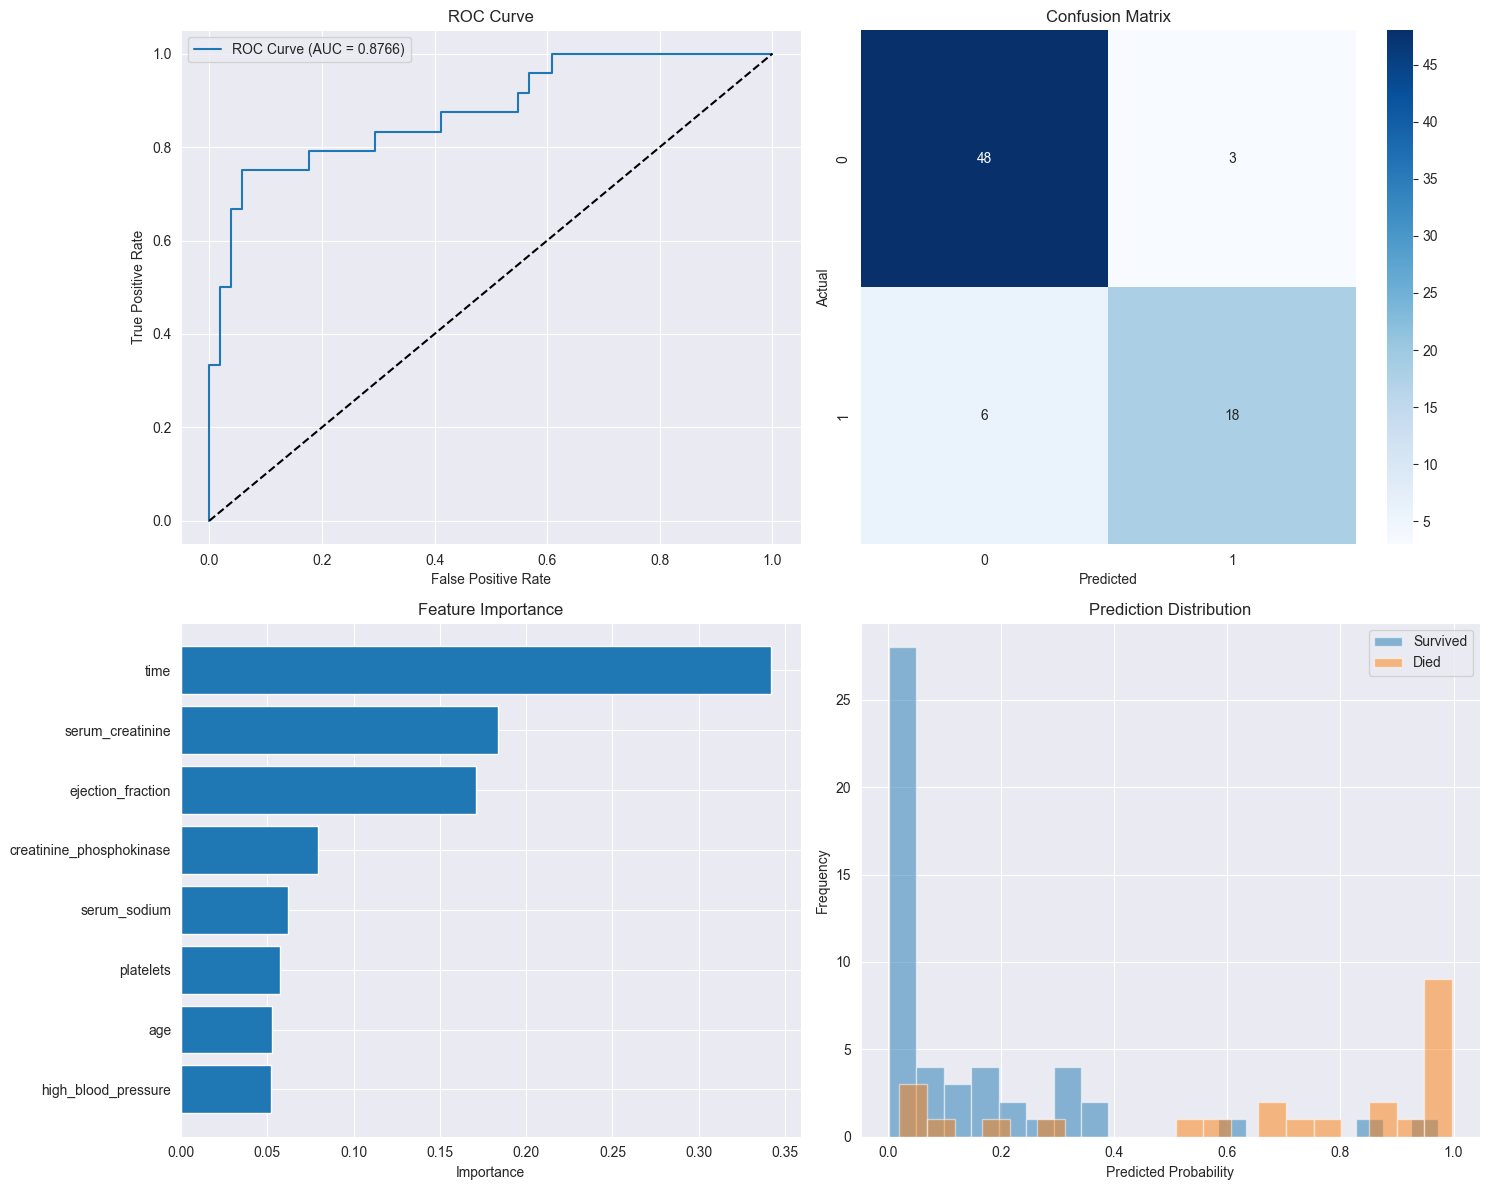


10. SHAP Analysis...


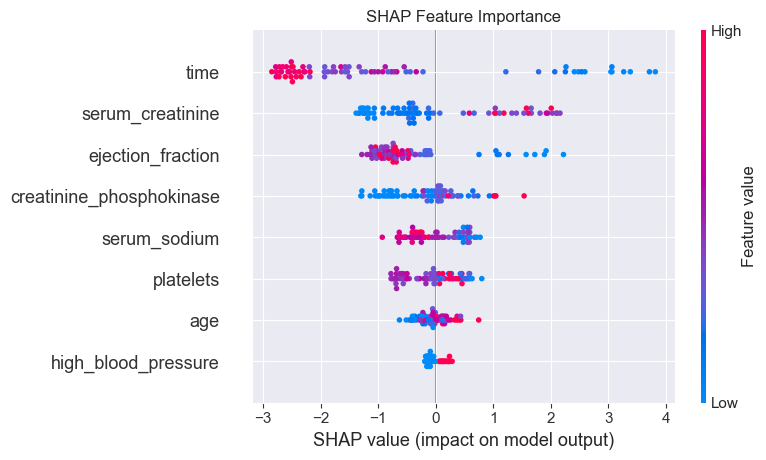


=== Pipeline completed successfully! ===

Running pipeline with PCA...
=== Heart Failure Prediction Pipeline ===
1. Loading data...
Data shape: (299, 13)
Missing values: 0
Target distribution:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64

2. Preprocessing data...
Features after preprocessing: (299, 12)

3. Splitting data (75/25)...
Training set: (224, 12)
Test set: (75, 12)
Training target distribution:
DEATH_EVENT
0    152
1     72
Name: count, dtype: int64

4. Balancing training data using smote...
Before balancing: {0: 152, 1: 72}
After balancing: {1: 152, 0: 152}

5. Feature selection using rf_importance...
Selected features (10): ['time', 'serum_creatinine', 'ejection_fraction', 'creatinine_phosphokinase', 'serum_sodium', 'platelets', 'age', 'high_blood_pressure', 'anaemia', 'smoking']

6. Applying dimensionality reduction using pca...
PCA components: 6
Explained variance ratio: 0.7207

7. Training XGBoost model...
Cross-validation AUC scores: [0.87526882 0.92688172 0.

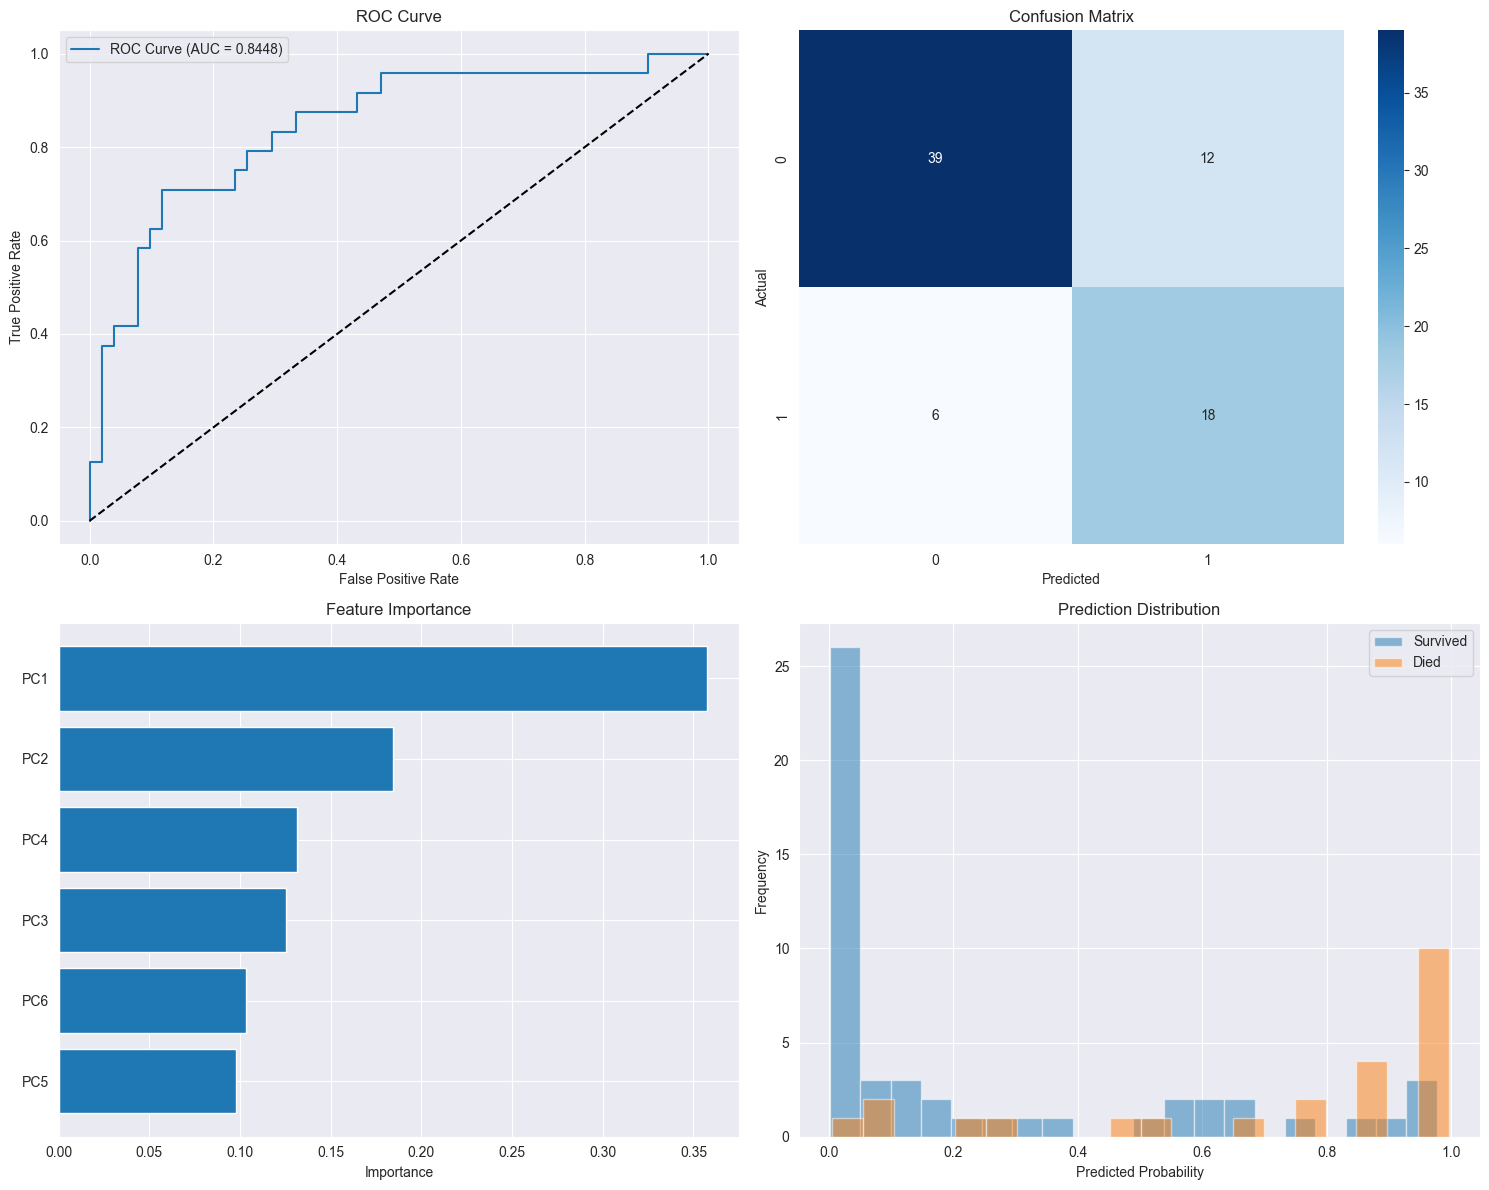


10. SHAP Analysis...


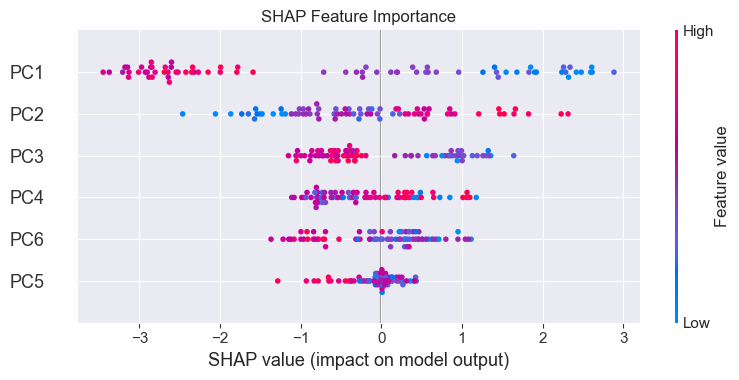


=== Pipeline completed successfully! ===


In [15]:
# Heart Failure Prediction Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, roc_curve, f1_score, confusion_matrix,
    classification_report, accuracy_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class HeartFailurePipeline:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.X_train_balanced = None
        self.y_train_balanced = None
        self.X_train_selected = None
        self.X_test_selected = None
        self.scaler = None
        self.feature_selector = None
        self.pca = None
        self.model = None
        self.selected_features = None

    def load_data(self):
        """1. Import data"""
        print("1. Loading data...")
        self.data = pd.read_csv(self.file_path)
        print(f"Data shape: {self.data.shape}")
        print(f"Missing values: {self.data.isnull().sum().sum()}")
        print(f"Target distribution:\n{self.data['DEATH_EVENT'].value_counts()}")
        return self.data

    def preprocess_data(self):
        """2. Preprocessing (encoding, normalization, handle missing)"""
        print("\n2. Preprocessing data...")

        # Separate features and target
        X = self.data.drop('DEATH_EVENT', axis=1)
        y = self.data['DEATH_EVENT']

        # Handle missing values (none in this dataset, but for robustness)
        if X.isnull().sum().sum() > 0:
            X = X.fillna(X.median())  # Fill with median for numerical features

        # Normalization
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

        print(f"Features after preprocessing: {X_scaled.shape}")
        return X_scaled, y

    def split_data(self, X, y, test_size=0.25):
        """3. Split train/test (75/25)"""
        print(f"\n3. Splitting data ({int((1-test_size)*100)}/{int(test_size*100)})...")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        print(f"Training set: {self.X_train.shape}")
        print(f"Test set: {self.X_test.shape}")
        print(f"Training target distribution:\n{self.y_train.value_counts()}")

        return self.X_train, self.X_test, self.y_train, self.y_test

    def balance_data(self, method='smote'):
        """4. Balancing (di training set saja)"""
        print(f"\n4. Balancing training data using {method}...")

        print(f"Before balancing: {self.y_train.value_counts().to_dict()}")

        if method == 'smote':
            balancer = SMOTE(random_state=42)
        elif method == 'undersampling':
            balancer = RandomUnderSampler(random_state=42)
        elif method == 'smoteenn':
            balancer = SMOTEENN(random_state=42)

        self.X_train_balanced, self.y_train_balanced = balancer.fit_resample(
            self.X_train, self.y_train
        )

        print(f"After balancing: {pd.Series(self.y_train_balanced).value_counts().to_dict()}")

        return self.X_train_balanced, self.y_train_balanced

    def select_features(self, method='rf_importance', n_features=10):
        """5. Feature selection (RF importance, RFE)"""
        print(f"\n5. Feature selection using {method}...")

        if method == 'rf_importance':
            # Random Forest Feature Importance
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            rf.fit(self.X_train_balanced, self.y_train_balanced)

            feature_importance = pd.DataFrame({
                'feature': self.X_train_balanced.columns,
                'importance': rf.feature_importances_
            }).sort_values('importance', ascending=False)

            self.selected_features = feature_importance.head(n_features)['feature'].tolist()

        elif method == 'rfe':
            # Recursive Feature Elimination
            rf = RandomForestClassifier(n_estimators=100, random_state=42)
            self.feature_selector = RFE(rf, n_features_to_select=n_features)
            self.feature_selector.fit(self.X_train_balanced, self.y_train_balanced)
            self.selected_features = self.X_train_balanced.columns[self.feature_selector.support_].tolist()

        elif method == 'univariate':
            # Univariate feature selection
            self.feature_selector = SelectKBest(f_classif, k=n_features)
            self.feature_selector.fit(self.X_train_balanced, self.y_train_balanced)
            self.selected_features = self.X_train_balanced.columns[self.feature_selector.get_support()].tolist()

        # Apply feature selection
        self.X_train_selected = self.X_train_balanced[self.selected_features]
        self.X_test_selected = self.X_test[self.selected_features]

        print(f"Selected features ({len(self.selected_features)}): {self.selected_features}")

        return self.X_train_selected, self.X_test_selected

    def apply_dimensionality_reduction(self, method='pca', n_components=0.95):
        """6. (Optional) PCA or Autoencoder"""
        print(f"\n6. Applying dimensionality reduction using {method}...")

        if method == 'pca':
            self.pca = PCA(n_components=n_components, random_state=42)
            self.X_train_selected = self.pca.fit_transform(self.X_train_selected)
            self.X_test_selected = self.pca.transform(self.X_test_selected)

            print(f"PCA components: {self.pca.n_components_}")
            print(f"Explained variance ratio: {self.pca.explained_variance_ratio_.sum():.4f}")

        elif method == 'autoencoder':
            # Simple dense autoencoder using sklearn's neural network
            from sklearn.neural_network import MLPRegressor

            # Encoder part
            encoder_dims = [self.X_train_selected.shape[1], 8, 4]  # Reduce to 4 dimensions

            # For simplicity, we'll use a basic approach
            # In practice, you might want to use TensorFlow/PyTorch for more control
            print("Note: Using PCA instead of autoencoder for simplicity")
            self.pca = PCA(n_components=4, random_state=42)
            self.X_train_selected = self.pca.fit_transform(self.X_train_selected)
            self.X_test_selected = self.pca.transform(self.X_test_selected)

        return self.X_train_selected, self.X_test_selected

    def train_model(self, use_cv=True, cv_folds=5):
        """7. Train model (XGBoost + cross validation)"""
        print(f"\n7. Training XGBoost model...")

        # XGBoost parameters
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
        }

        self.model = xgb.XGBClassifier(**params)

        if use_cv:
            # Cross-validation
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
            cv_scores = cross_val_score(
                self.model, self.X_train_selected, self.y_train_balanced,
                cv=cv, scoring='roc_auc'
            )

            print(f"Cross-validation AUC scores: {cv_scores}")
            print(f"Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        # Fit final model
        self.model.fit(self.X_train_selected, self.y_train_balanced)

        return self.model

    def test_model(self):
        """8. Test model on hold-out test set"""
        print(f"\n8. Testing model on hold-out test set...")

        # Predictions
        y_pred = self.model.predict(self.X_test_selected)
        y_pred_proba = self.model.predict_proba(self.X_test_selected)[:, 1]

        # Store results
        self.test_results = {
            'y_true': self.y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        return y_pred, y_pred_proba

    def evaluate_model(self):
        """9. Evaluate (ROC, F1, Confusion matrix, SHAP)"""
        print(f"\n9. Model evaluation...")

        y_true = self.test_results['y_true']
        y_pred = self.test_results['y_pred']
        y_pred_proba = self.test_results['y_pred_proba']

        # Metrics
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)

        print(f"Test Set Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC-ROC: {auc:.4f}")

        # Classification report
        print(f"\nClassification Report:")
        print(classification_report(y_true, y_pred))

        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        axes[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
        axes[0, 0].plot([0, 1], [0, 1], 'k--')
        axes[0, 0].set_xlabel('False Positive Rate')
        axes[0, 0].set_ylabel('True Positive Rate')
        axes[0, 0].set_title('ROC Curve')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # 2. Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
        axes[0, 1].set_xlabel('Predicted')
        axes[0, 1].set_ylabel('Actual')
        axes[0, 1].set_title('Confusion Matrix')

        # 3. Feature Importance (XGBoost)
        if hasattr(self.model, 'feature_importances_'):
            if self.pca is not None:
                feature_names = [f'PC{i+1}' for i in range(self.X_train_selected.shape[1])]
            else:
                feature_names = self.selected_features

            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=True)

            axes[1, 0].barh(importance_df['feature'], importance_df['importance'])
            axes[1, 0].set_xlabel('Importance')
            axes[1, 0].set_title('Feature Importance')

        # 4. Prediction Distribution
        axes[1, 1].hist(y_pred_proba[y_true == 0], alpha=0.5, label='Survived', bins=20)
        axes[1, 1].hist(y_pred_proba[y_true == 1], alpha=0.5, label='Died', bins=20)
        axes[1, 1].set_xlabel('Predicted Probability')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Prediction Distribution')
        axes[1, 1].legend()

        plt.tight_layout()
        plt.show()

        # SHAP Analysis
        print(f"\n10. SHAP Analysis...")
        try:
            explainer = shap.TreeExplainer(self.model)
            shap_values = explainer.shap_values(self.X_test_selected)

            # SHAP Summary Plot
            if self.pca is not None:
                feature_names = [f'PC{i+1}' for i in range(self.X_train_selected.shape[1])]
            else:
                feature_names = self.selected_features

            plt.figure(figsize=(10, 6))
            shap.summary_plot(shap_values, self.X_test_selected,
                            feature_names=feature_names, show=False)
            plt.title('SHAP Feature Importance')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"SHAP analysis failed: {e}")

    def run_pipeline(self, balance_method='smote', feature_selection='rf_importance',
                    n_features=10, apply_pca=False, pca_components=0.95):
        """Run the complete pipeline"""
        print("=== Heart Failure Prediction Pipeline ===")

        # 1. Load data
        self.load_data()

        # 2. Preprocess
        X, y = self.preprocess_data()

        # 3. Split
        self.split_data(X, y)

        # 4. Balance
        self.balance_data(method=balance_method)

        # 5. Feature selection
        self.select_features(method=feature_selection, n_features=n_features)

        # 6. Dimensionality reduction (optional)
        if apply_pca:
            self.apply_dimensionality_reduction(method='pca', n_components=pca_components)

        # 7. Train model
        self.train_model()

        # 8. Test model
        self.test_model()

        # 9. Evaluate
        self.evaluate_model()

        print("\n=== Pipeline completed successfully! ===")

# Example usage
if __name__ == "__main__":
    # Initialize pipeline
    pipeline = HeartFailurePipeline('satzet/heart_failure_clinical_records_dataset.csv')

    # Run complete pipeline with default settings
    pipeline.run_pipeline(
        balance_method='smote',           # 'smote', 'undersampling', 'smoteenn'
        feature_selection='rf_importance', # 'rf_importance', 'rfe', 'univariate'
        n_features=8,                     # Number of features to select
        apply_pca=False,                  # Whether to apply PCA
        pca_components=0.95               # PCA components (variance to retain)
    )

    # Optional: Run with PCA
    print("\n" + "="*50)
    print("Running pipeline with PCA...")
    pipeline_pca = HeartFailurePipeline('satzet/heart_failure_clinical_records_dataset.csv')
    pipeline_pca.run_pipeline(
        balance_method='smote',
        feature_selection='rf_importance',
        n_features=10,
        apply_pca=True,
        pca_components=6  # Fixed number of components
    )